In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
% matplotlib inline
#check to see if I can control how big each holdout set is, do with rms error

from sklearn.cross_validation import cross_val_score 
from sklearn.cross_validation import KFold
import sklearn.preprocessing as pp
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn import cross_validation
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
import sklearn.decomposition
import sklearn.ensemble as sk
from sklearn import linear_model

import random
import sys
from scipy import stats

#Import Data

In [50]:
df_all = pd.io.parsers.read_csv(filepath_or_buffer = 'data/D3_raw_features.csv', parse_dates = [0], index_col = 0)

#Randomized Principal Component Analysis

In [51]:
#from sklearn.decomposition import RandomizedPCA
#features = list(df_all.columns)
#pca = RandomizedPCA()
#df_pca = df_all[features].apply(lambda x: pca.fit_transform(x))

###Delete the unfiltered data

In [52]:
#df_all.drop(df_all.columns[[1,5]], axis=1, inplace=True)
#print df_all[:5]

##Declare whether to process raw or filtered data.

In [53]:
which_data = 0    #1 = filtered, 0 = raw
if which_data == 0:
    ref_column = 'O3_ppb'
    leave_out_pod = 'pod_o3_smooth'
    pod_ozone = 'e2v03'
else:
    ref_column = 'ref_o3_smooth'
    leave_out_pod = 'e2v03'
    pod_ozone = 'pod_o3_smooth'

####Define a function that makes numpy arrays out of the training and holdout data.

In [54]:
def make_numpy_arrays_for_tr_and_holdout(features, df_T, df_H):
    X_T = df_T[features].values
    X_H = df_H[features].values
    y_T = df_T[ref_column].values
    y_H = df_H[ref_column].values
    return X_T, y_T, X_H, y_H

####Scale the features and cadd a 'day' column to the dataframe.

In [55]:
features = list(df_all.ix[:,1:len(df_all.columns)])
def scale_features_and_create_day_column(df_all, features, ref_column):
    
    #Center feature values around zero and make them all have variance on the same order.
    df_scaled = df_all.copy()
    #for i in range(0,len(features)):
     #   df_scaled[features[i]] = pp.scale(df_all[features[i]].values)
    df_scaled = df_all[features].apply(lambda x: pp.scale(x))
    df_sc = pd.concat([df_scaled, df_all[ref_column]], axis = 1)
    #create a 'day' column in the dataframe by mapping the index column
    df_sc['day'] = df_sc.index.map(lambda dt: str(dt.month) + '-' + str(dt.day))
    days = df_sc['day'].unique()
    
    return df_sc, days

####Call the scaling function and create a dataframe with scaled data that has a day column.

In [56]:
df_scaled, days = scale_features_and_create_day_column(df_all, features, ref_column)

####Define a custom cross-validation function.

In [57]:
labels = df_scaled['day'].values
lol = cross_validation.LeaveOneLabelOut(labels)

####Declare a neutral fitting function.

In [58]:
#Takes a model, and training and holdout data, and returns training and holdout data
def fitting_func(model, X_T, y_T, X_H, y_H):    
    #fit a linear regression on the training data
    model.fit(X_T, y_T)   
    #find the normalized MSE for the training and holdout data
    return np.mean((y_H - model.predict(X_H))**2), np.mean((y_T - model.predict(X_T))**2)

####Define a function that loops through all of the days (CV by day), and computes MSE.

In [59]:
def cross_validation_by_day(model, features, df):

    #initialize the holdout and training MSE
    day_date = []
    MSE_H = [] 
    MSE_T = []
    #Calculate the training and holdout RSS for each step.
    #take the mean MSE for all of the possible holdout days (giving cross-validation error)
    for d in days:
        
        #call the df_subset function to make numpy arrays out of the training and holdout data
        X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features, df[df.day != d], df[df.day == d])
                
        MSE_H_day, MSE_T_day = fitting_func(model, X_T, y_T, X_H, y_H)
         
        #record the MSE for lambda for the day
        MSE_H.append(MSE_H_day)
        MSE_T.append(MSE_T_day)
    
        #record the day
        day_date.append(d)
            
        #find the mean MSE of all of the days for the given value of lambda
        mean_cv_MSE_all_days = np.mean(MSE_H)
        mean_train_MSE_all_Days = np.mean(MSE_T)

    return mean_cv_MSE_all_days, mean_train_MSE_all_Days 

#Linear Regression with Base Features

In [60]:
base_features = [pod_ozone,'Temp','Rh']

In [61]:
#Define the model.
lin_regr = linear_model.LinearRegression()
#find the MSE
MSE_H, MSE_T = cross_validation_by_day(lin_regr, base_features, df_scaled)
print "Holdout MSE: ", int(MSE_H), " Training MSE: ", int(MSE_T)

Holdout MSE:  36  Training MSE:  33


####Define a function to plot the learning curve

In [62]:
from sklearn.learning_curve import learning_curve

def plot_learning_curve(estimator, title, X, y, ylimit, cv, train_sizes, scoring):

    plt.figure()
    plt.title(title)
    if ylimit is not None:
        plt.ylim(ylimit)
    plt.xlabel("Training examples")
    plt.ylabel("Mean Squared Error")
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y, cv = cv, train_sizes = train_sizes, scoring = scoring)
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = -np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training error")
    plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation error")

    plt.legend(loc="best")
    return plt

###Call the learning curve function for a linear regression with the base features.

<module 'matplotlib.pyplot' from '/Applications/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

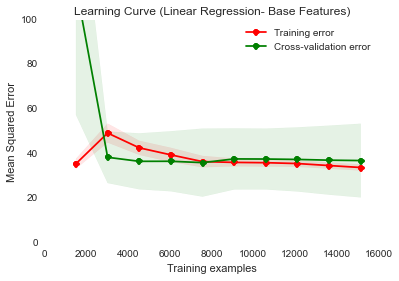

In [63]:
base_features = [pod_ozone,'Temp','Rh']

X = df_all[base_features].values
y = df_all[ref_column].values
title = "Learning Curve (Linear Regression- Base Features)"
cv = lol
ylim = (0,100)
train_sizes = np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plot_learning_curve(lin_regr, title, X, y, ylim, cv, train_sizes, 'mean_squared_error')

The MSE is high for the cross-validation set in this plot, and the training and cross-validation scores come together in this plot tells us that we have resonably high bias. Create more features and add polynomial effects to reduce bias. 

####Plot a learning curve with all features.

<module 'matplotlib.pyplot' from '/Applications/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

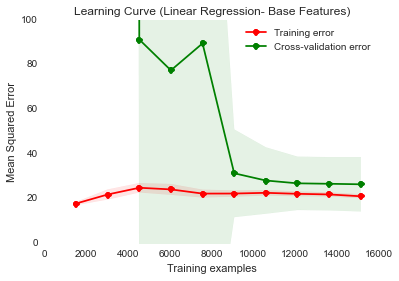

In [64]:
#change the features list to include all features and polynomials
all_features = list(df_all.ix[:,2:len(df_all.columns)])
X = df_all[all_features].values
y = df_all[ref_column].values

title = "Learning Curve (Linear Regression- Base Features)"
cv = lol
ylim = (0,100)
train_sizes = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plot_learning_curve(lin_regr, title, X, y, ylim, cv, train_sizes, 'mean_squared_error')

The uncertainty in the cross-validation score is enormous, and it's very far away, from the training score, which indicates that we now have high variance, and need to reduce the number of features.

#Forward Selection

In [90]:
from sklearn.metrics import make_scorer
def custom_scoring_function(y, y_pred):
    low_sum = np.mean(0.1*(y[y < 45] - y_pred[y < 45])**2)
    high_sum = np.mean((y[y >= 45] - y_pred[y >= 45])**2)
    if np.isnan(low_sum) == True:
        low_sum = 0
    if np.isnan(high_sum) == True:
        high_sum = 0
    ##print int(low_sum), int(high_sum)
    return int(low_sum + high_sum)

In [91]:
def avg_cv_score_for_all_days(df, features, ref_column, model, scoring_metric):
    X = df[features].values
    y = df[ref_column].values
    if scoring_metric == 'custom':
        score_cv = -np.mean(cross_val_score(model, X, y, cv = lol, scoring = make_scorer(custom_scoring_function, greater_is_better = False)))        
    else:
        score_cv = -np.mean(cross_val_score(model, X, y, cv = lol, scoring = scoring_metric))
    return score_cv

In [92]:
def new_forward_selection_step(model, b_f, features, df, ref_column, scoring_metric):
    #initialize min_MSE with a very large number
    min_score = sys.maxint
    min_r2 = 0
    next_feature = ''

    for f in features:
        score_step = avg_cv_score_for_all_days(df, b_f + [f], ref_column, model, scoring_metric)
        if score_step < min_score:
            min_score = score_step
            next_feature = f
            score_cv = "{:.1f}".format(min_score)   
    return next_feature, score_cv

In [93]:
def new_forward_selection_lodo(model, features, df, scoring_metric):
    #initialize the best_features list with the base features to force their inclusion
    best_features = []
    #call the function that scales the features and creates a day column   
    
    score_cv = []
    while len(features) > 0:
        next_features = []
        score_cv_list = []
             
        next_feature, score_cv_feat = new_forward_selection_step(model, best_features, features, df, ref_column, scoring_metric)
        print next_feature, ':', score_cv_feat
        #add the next feature to the list
        best_features += [next_feature]
        score_cv.append(score_cv_feat)
        #remove the added feature from the list
        features.remove(next_feature)

    return best_features, score_cv

###Try it

In [94]:
#Declare rather you want to use MSE or a custom error function:
error_func = 'custom' #'custom' or 'mean_squared_error'

In [95]:
#make a list of features from the column titles in the dataframe
features = list(df_all.columns)
#this lets you leave out anything you want
leave_out = ['Zenith Angle [degrees]','UnixTime',leave_out_pod, ref_column]
features = [f for f in features if f not in leave_out]
#Define the model.
lin_regr = linear_model.LinearRegression()

In [97]:
fs_features, score = new_forward_selection_lodo(lin_regr, features, df_scaled[[ref_column] + features].dropna(), error_func)
print fs_features

ln_O3 : 136.7
temp_int_60 : 57.6
ln_temp_mult_rh : 35.3
ln_temp_int_90 : 32.8
o3_slope_15 : 32.2
03_mult_temp : 31.4
ln_rh_int_90 : 31.0
diff : 30.3
rh_slope_30 : 30.1
03_mult_rh_&_temp_sq : 29.8
days from start : 29.3
o3_slope_5 : 29.2
03_mult_rh_sq : 29.0
rh_slope_45 : 29.0
ln_03_mult_rh_&_temp_cu : 28.8
o3_slope_45 : 28.8
o3_int_90 : 28.7
rh_slope_90 : 28.7


KeyboardInterrupt: 

['131.2', '59.3', '40.2', '38.8', '38.2', '37.2', '38.7', '36.4', '35.8', '34.7', '33.0', '31.5', '31.0', '30.8', '30.2', '30.2', '30.2', '30.1', '29.9', '30.3', '30.1', '30.1', '30.2', '30.2', '30.0', '30.1', '30.2', '29.9', '30.6', '30.7', '30.6', '30.4', '30.7', '30.5', '30.4', '30.8', '30.7', '30.5', '30.3', '30.5', '30.8', '30.7', '30.4', '30.5', '30.8', '30.9', '31.1', '31.2', '30.9', '31.5', '31.7', '31.7', '31.1', '31.2', '31.7', '31.6', '31.1', '30.8', '30.7', '30.8', '31.2', '30.9', '30.8', '30.8', '30.8', '30.4', '30.8', '30.9', '31.3', '31.1', '31.3', '31.2', '31.4', '31.4', '31.6', '31.5', '32.2', '32.6', '34.2', '33.5', '33.9']


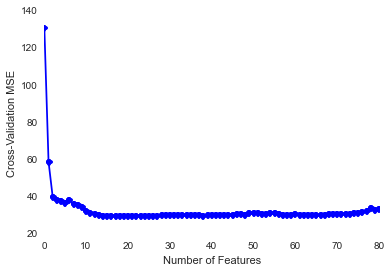

In [74]:
x = range(0, len(score))
plt.figure()
plt.plot(x, score, 'bo-')
plt.xlabel('Number of Features')
plt.ylabel('Error')
print score

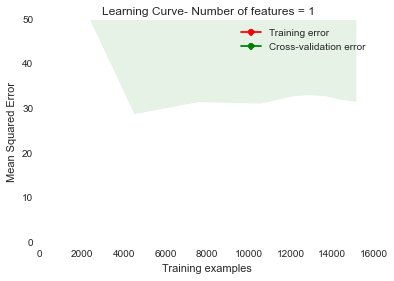

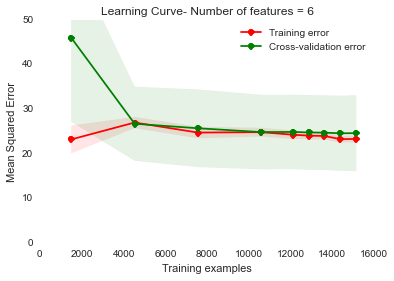

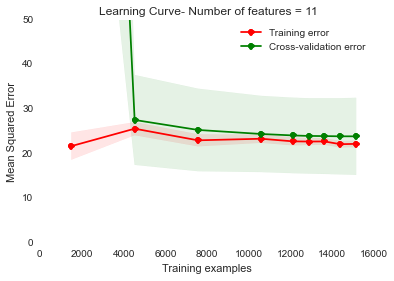

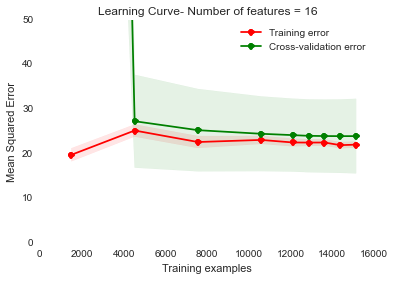

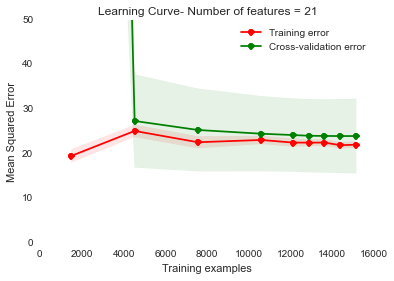

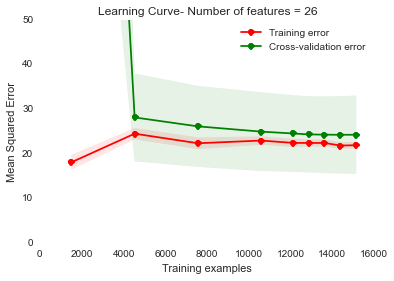

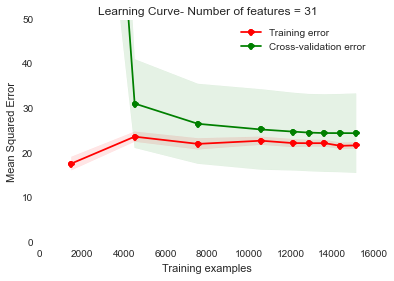

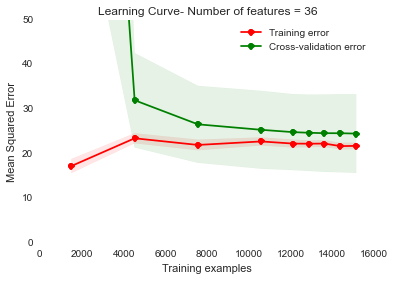

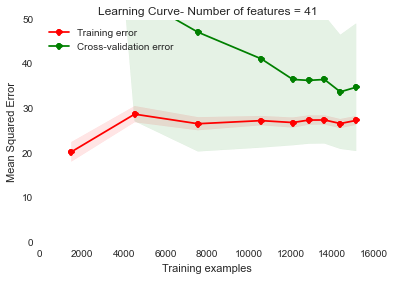

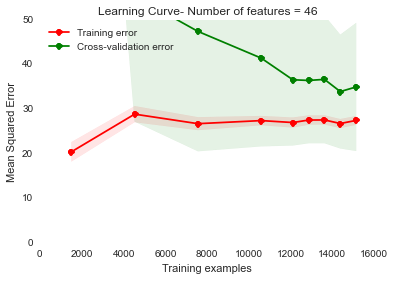

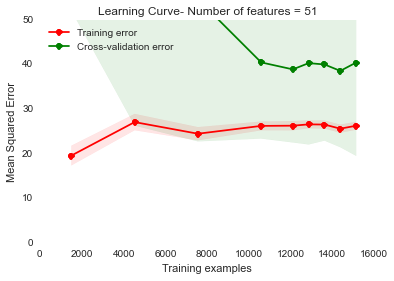

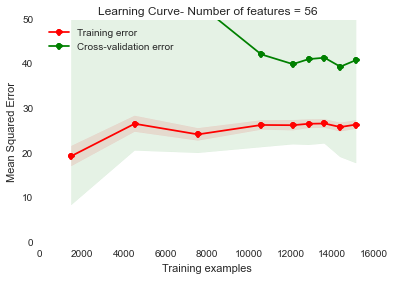

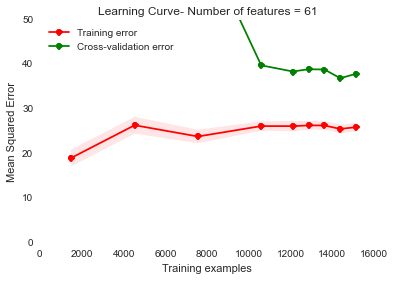

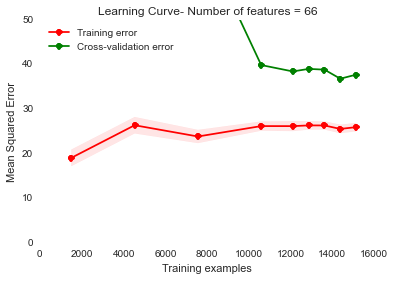

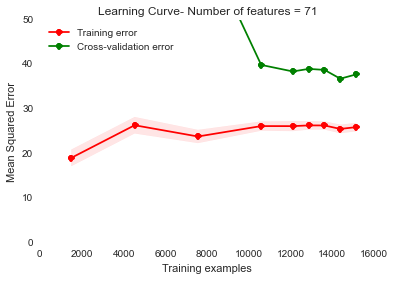

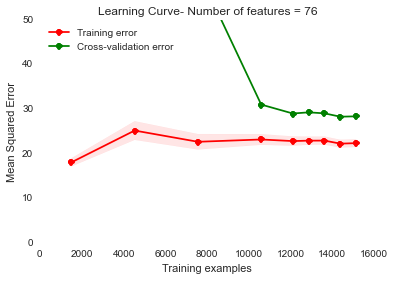

In [82]:
cv = lol
ylim = (0,50)
train_sizes = np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0])
#declare the reference data 
y = df_scaled[ref_column].values

i = 1
while i <= len(fs_features):
    X = df_all[fs_features[:i]].values 
    title = "Learning Curve- Number of features = " + str(i)
    plot_learning_curve(lin_regr, title, X, y, ylim, cv, train_sizes, 'mean_squared_error')
    i += 5

#Check Residuals

In [83]:
def fitted_vs_ref_plot(df):
    plt.figure(figsize = (5,5))
    plt.plot(df[ref_column],df.O3_fit,linestyle = '',marker = '.',alpha = 0.3)
    plt.xlabel('Reference O3 Conc.')
    plt.ylabel('Predicted O3 Conc (Holdout)')
    plt.plot([1,df[ref_column].max()],[1,df[ref_column].max()])

In [84]:
def plot_fitted_and_ref_vs_time(df,xlim):
    plt.figure(figsize = (15,10))
    df_lin_regr_best_feat[ref_column].plot(marker = '.',linestyle = ' ',)
    df_lin_regr_best_feat.O3_fit.plot(marker = '.',linestyle = '-', xlim=xlim)
    plt.ylabel('Residual Value')

In [85]:
def plot_resid_vs_conc(df):
    #find the residuals
    resid = df[ref_column] - df.O3_fit
    #plot the residuals to check for non-linearity of response predictor
    plt.figure(figsize = (15,5))
    plt.plot(df.O3_fit,lin_resid,linestyle = '',marker = '.',alpha = 0.4)
    plt.plot([-40,70],[0,0], linestyle = '--')
    plt.xlabel('Fitted O3 Conc.')
    plt.ylabel('Residuals')
    return resid

In [86]:
def plot_resid_vs_time(resid, xlim):
    plt.figure(figsize = (15,5))
    resid.plot(linestyle = '',marker = '.', xlim = xlim)
    #plt.plot([0,0],[70,0])
    plt.xlabel('Fitted O3 Conc.')
    plt.ylabel('Residuals')

###Find predicted ozone values for the holdout data. Enter the number of good features to use for regressions.

In [87]:
def find_fitted_cv_values_for_best_features(df, fs_features, num_good_feat, Model):
    fitted_holdout_o3 = []
    for d in days:    
        #call the df_subset function to make numpy arrays out of the training and holdout data
        X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(fs_features[:num_good_feat], df[df.day != d], df[df.day == d]) 
        #fit a linear regression on the training data
        model = Model
        model.fit(X_T, y_T)
        
        if d == days[0]:
            fitted_holdout_o3 = model.predict(X_H)
        else:
            fitted_holdout_o3 = np.concatenate((fitted_holdout_o3, model.predict(X_H)))

    df_lin_regr_best_feat = df_all.copy()
    df_lin_regr_best_feat['O3_fit'] = fitted_holdout_o3
    return df_lin_regr_best_feat

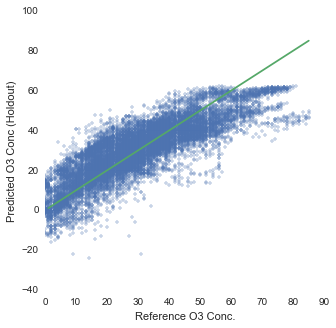

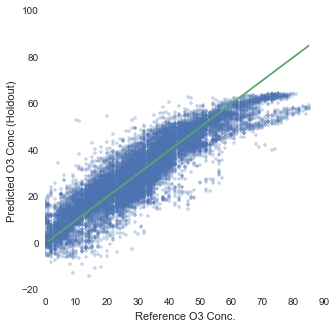

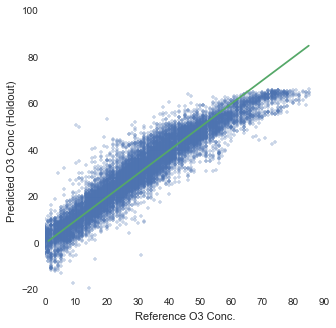

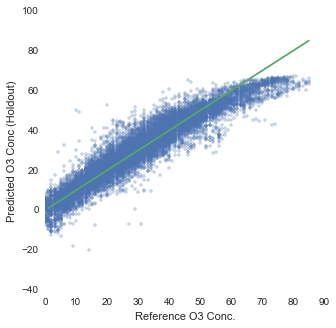

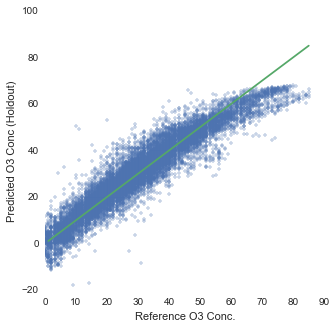

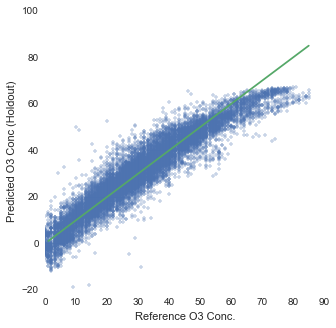

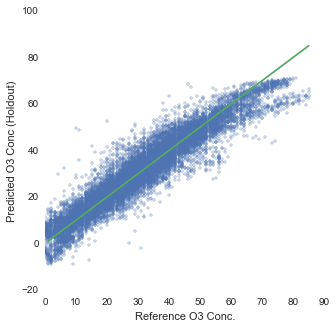

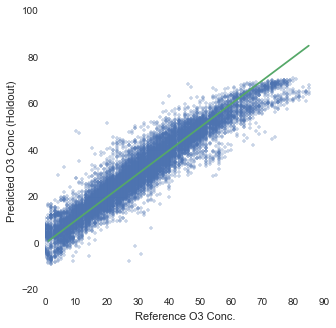

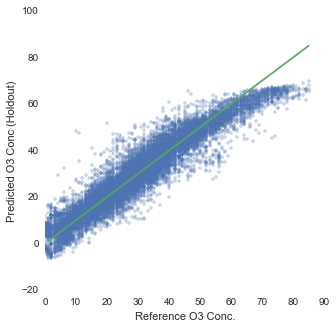

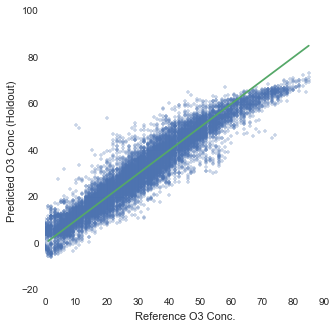

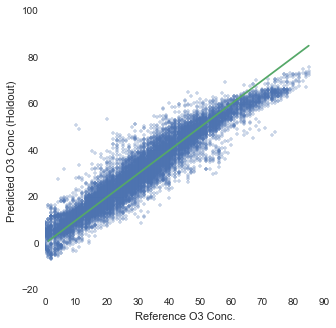

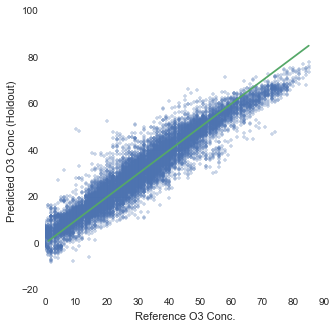

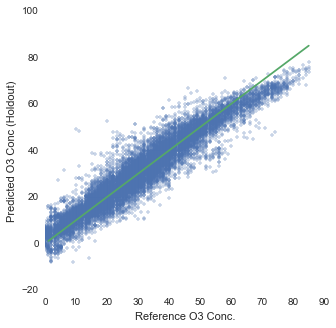

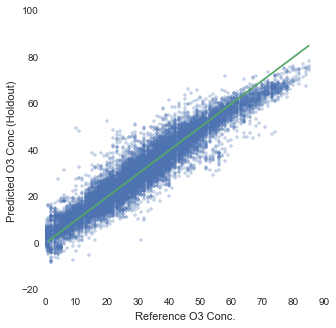

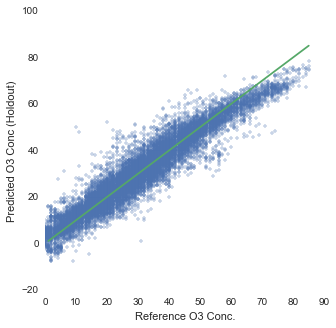

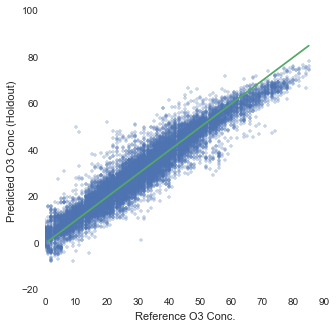

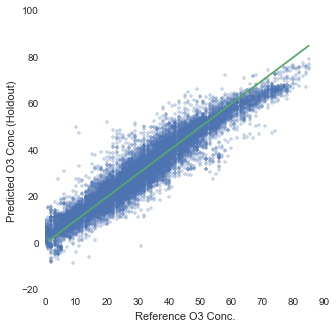

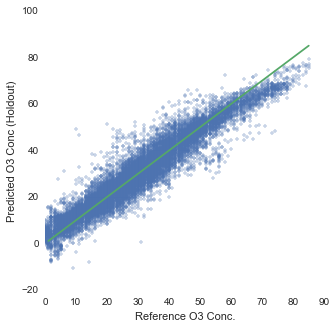

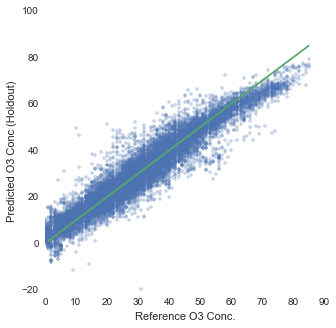

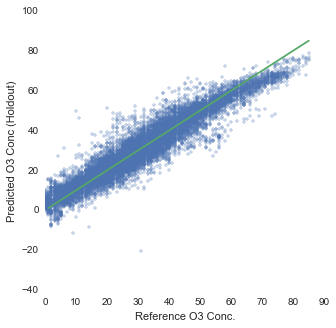

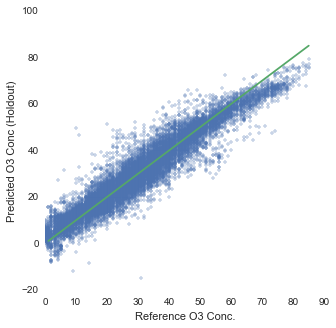

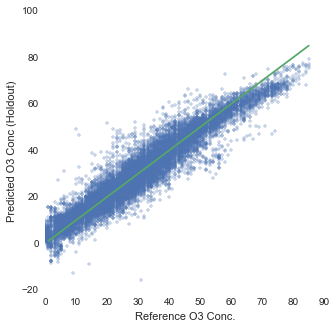

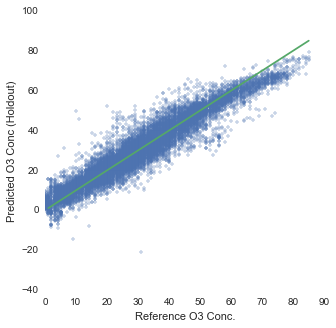

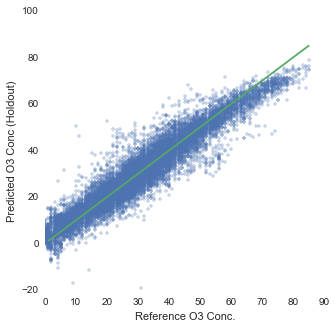

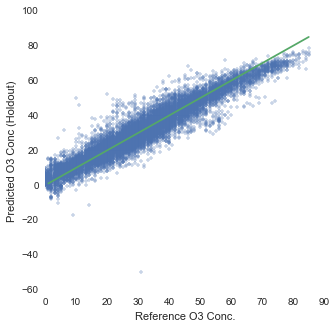

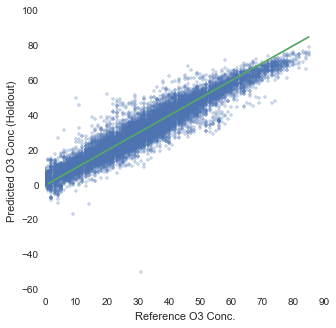

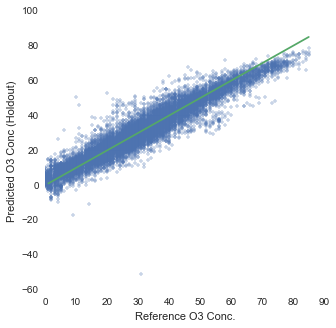

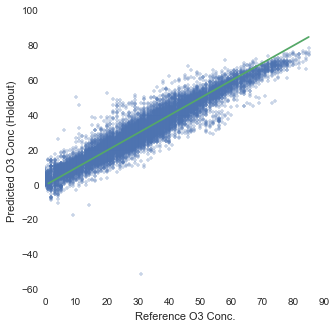

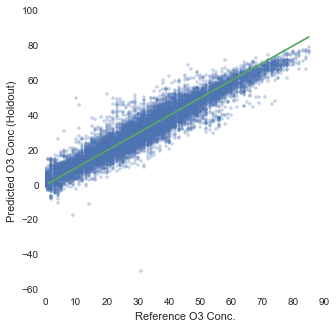

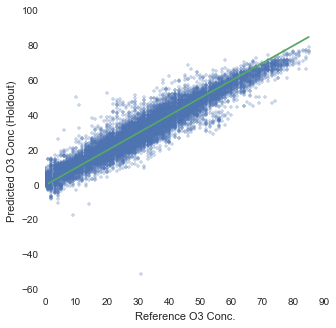

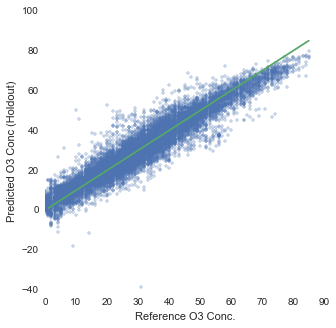

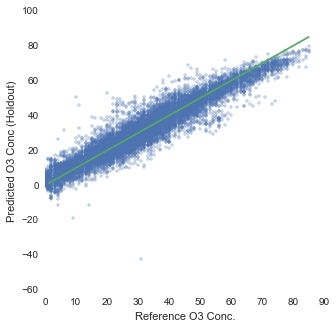

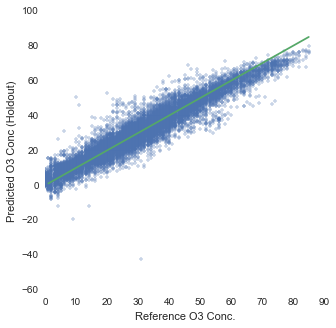

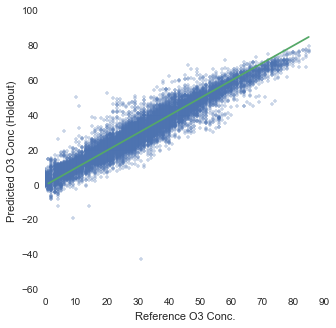

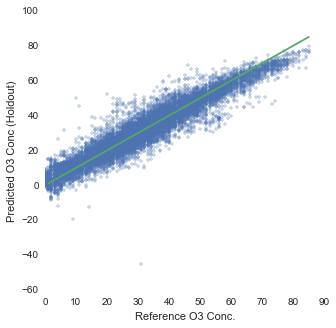

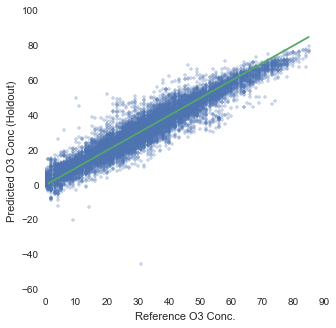

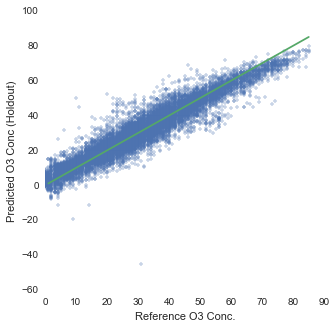

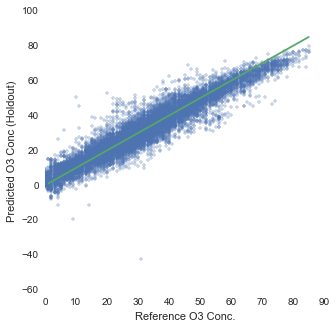

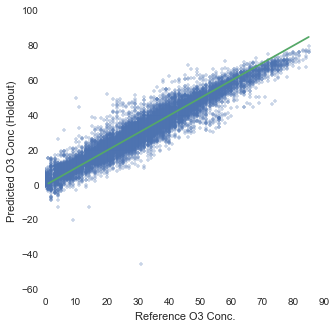

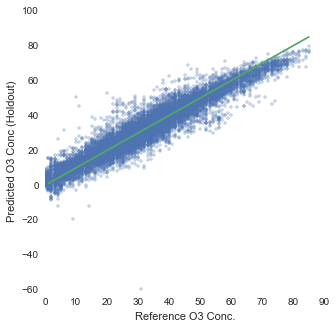

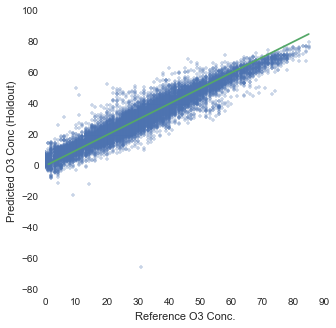

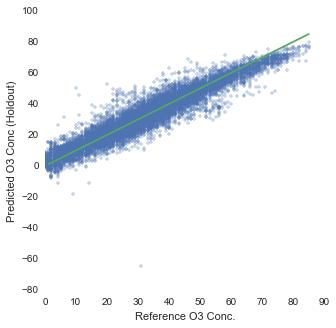

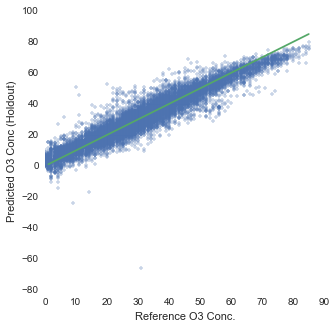

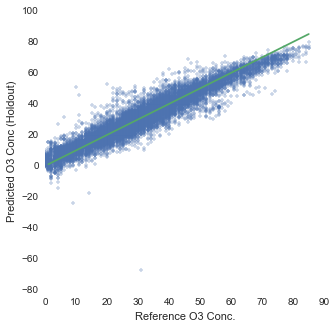

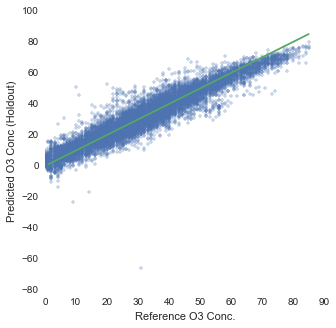

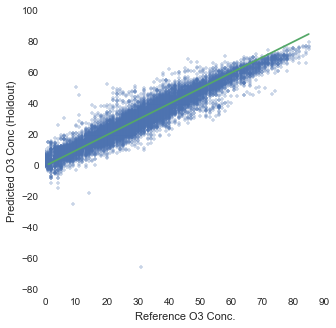

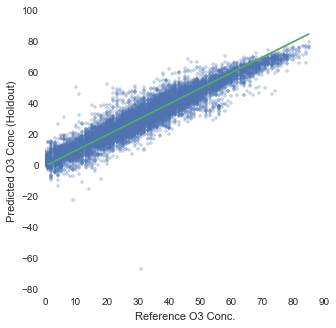

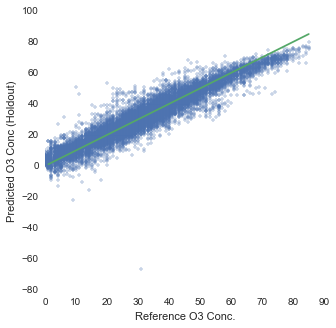

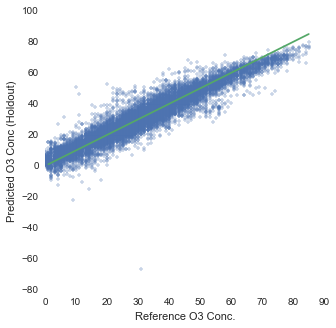

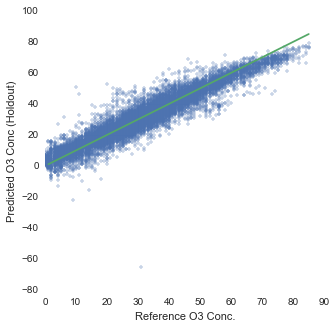

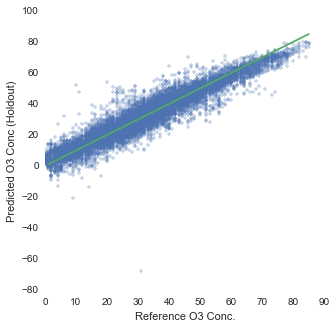

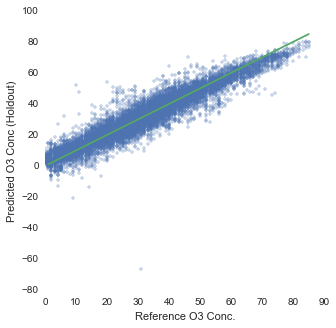

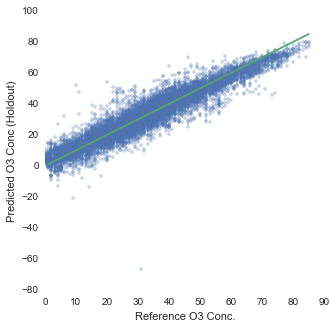

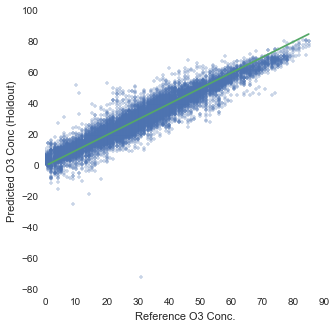

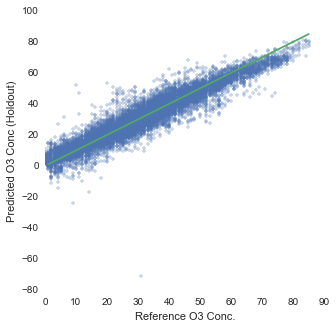

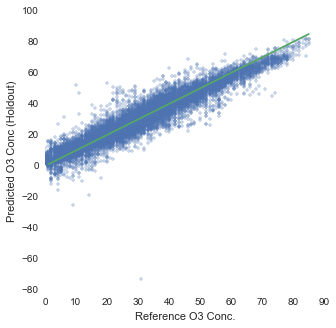

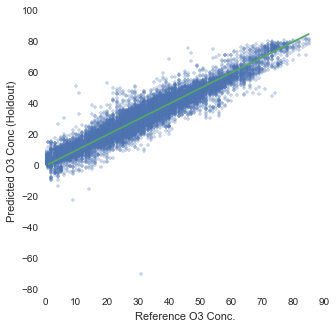

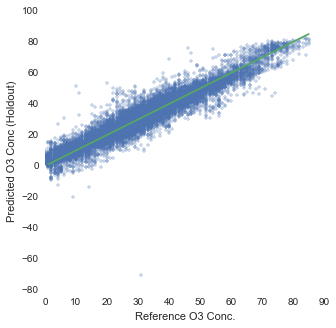

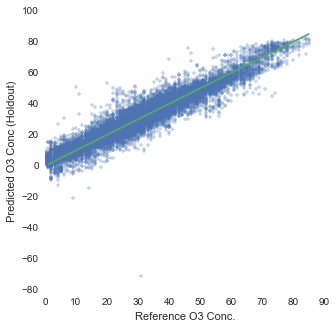

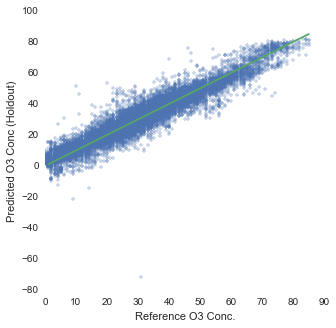

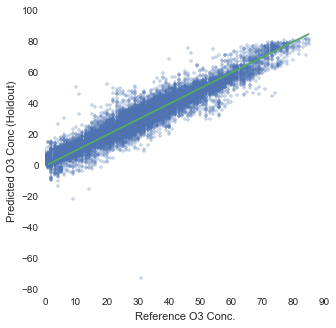

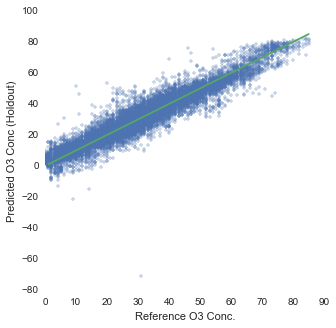

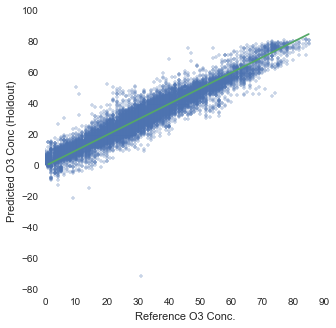

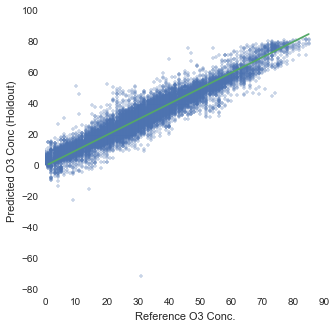

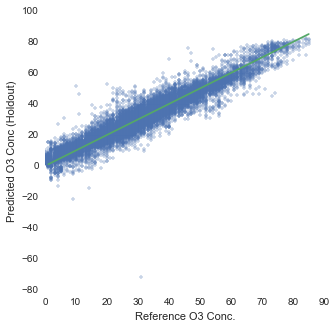

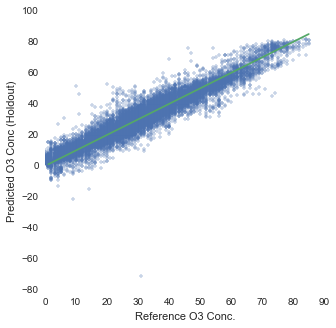

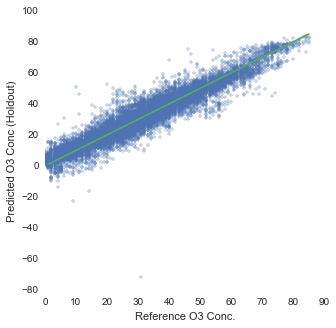

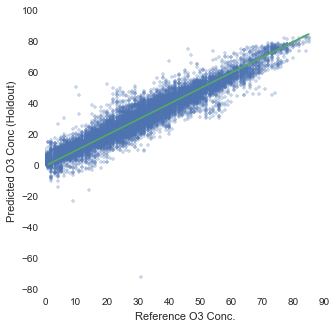

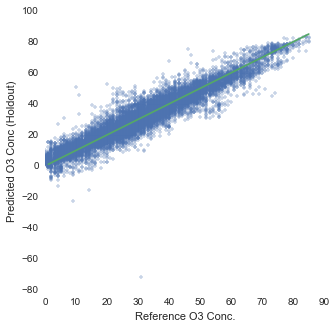

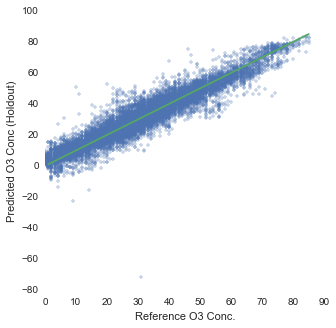

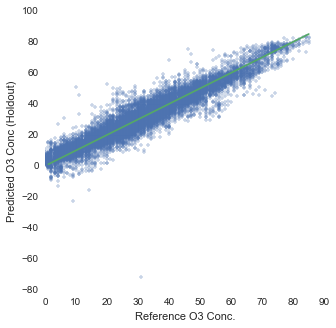

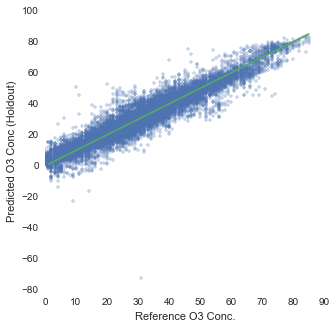

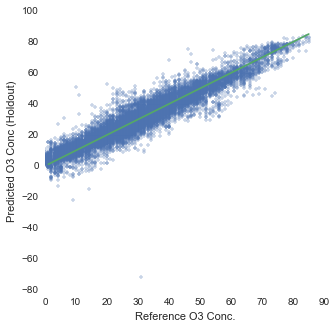

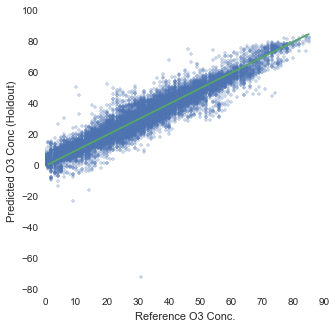

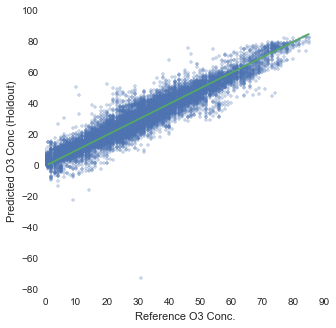

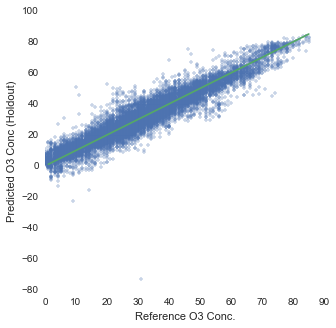

In [89]:
for i in range(1,len(fs_features)):
    num_good_feat = i
    df = find_fitted_cv_values_for_best_features(df_scaled, fs_features_custom, num_good_feat, linear_model.LinearRegression())
    fitted_vs_ref_plot(df) 

In [ ]:
fitted_vs_ref_plot(df_lin_regr_best_feat)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat, ['2014-07-11 00:00:00', '2014-07-13 00:00:00'])
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat, ['2014-08-30 00:00:00', '2014-09-4 00:00:00'])
resid = plot_resid_vs_conc(df_lin_regr_best_feat)
plot_resid_vs_time(resid, ['2014-08-30 00:00:00', '2014-09-5 00:00:00'])
plot_resid_vs_time(resid, ['2014-07-11 00:00:00', '2014-07-13 00:00:00'])

In [ ]:
print ("Mean Squared Error: %.2f" %
        np.mean((df_lin_regr_best_feat[ref_column] - df_lin_regr_best_feat['O3_fit']) ** 2))

#Ridge Regression

In [ ]:
#fs_features = ['e2v03','Temp','Rh']
num_good_feat = len(fs_features)

In [ ]:
#define the training data
df_ridge = df_scaled[fs_features[:num_good_feat] + [ref_column]+ ['day']].dropna()
X = df_scaled[fs_features[:num_good_feat]].values
y = df_scaled[ref_column].values
#print df_fit[:5]

###Find the best lambda value using cross-validation

In [ ]:
def find_best_lambda(Model, features, df):
    lambda_ridge = []
    mean_MSE_lambda_all_days = []
    day_date = []
    i = 0.00000000005
    n = 1
    coefs = []

    while i < 100:
        model = Model(alpha=i)
        MSE_ridge = []
    
        #initialize the holdout and training RSS
        MSE_T_day = []
        MSE_H_day = [] 
        #Calculate the training and holdout RSS for each step.
        #take the mean MSE for all of the possible holdout days (giving cross-validation error)
        for d in days:
                
            #call the function that defines the training and holdout data
            X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features, df[df.day != d], df[df.day == d])  
            #fit the ridge regression for the lambda
            model.fit(X_T, y_T)
            #get the cross-validation MSE for the lambda and day
            MSE_H_day = int(np.mean((y_H - model.predict(X_H))**2))
            #record the MSE for lambda for the day
            MSE_ridge.append(MSE_H_day)
            #record the day
            day_date.append(d)

        #find the mean MSE of all of the days for the given value of lambda
        mean_MSE_lambda_all_days.append(np.mean(MSE_ridge))
        #record the lambda value for this run
        lambda_ridge.append(i)
        #record the coefficients for this run
        coefs.append(model.coef_)
        
        i = i*2
        n += 1
    

    #find the lambda value (that produces the lowest cross-validation MSE)  
    best_lambda = lambda_ridge[mean_MSE_lambda_all_days.index(min(mean_MSE_lambda_all_days))]
                                
    #plot the coefficients     
    ax = plt.gca()
    ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm'])

    ax.plot(lambda_ridge, coefs)
    ax.set_xscale('log')
    plt.xlabel('lambda')
    plt.ylabel('weights')
    plt.title(str(Model) + 'coefficients as a function of the regularization')
    plt.show()  

    
    #plot the results
    plt.plot(lambda_ridge, mean_MSE_lambda_all_days)
    ax = plt.gca()
    ax.set_xscale('log')
    plt.xlabel('lambda')
    plt.ylabel('Cross-Validation MSE')
    
    return best_lambda, min(mean_MSE_lambda_all_days)

In [ ]:
best_lambda, MSE_H = find_best_lambda(Ridge, fs_features[:num_good_feat], df_ridge)
print 'Best Lambda: ', best_lambda
print 'Holdout Mean Squared Error: ', int(MSE_H)

####Use the best lambda value found above to find holdout values.

In [ ]:
def find_residuals_and_fitted_cv_values(Model, df_scaled, features, df_all):
    model = Model(alpha = best_lambda)

    for d in days:               
        #call the function that defines the training and holdout data
        X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features, df_scaled[df_scaled.day != d], df_scaled[df_scaled.day == d])  
        #fit the ridge regression for the lambda
        model.fit(X_T, y_T)
        if d == days[0]:
            fitted_holdout_o3 = model.predict(X_H)
        else:
            fitted_holdout_o3 = np.concatenate((fitted_holdout_o3, model.predict(X_H)))
                
    df_ridge_fit = df_all.copy()
    df_ridge_fit['O3_fit'] = fitted_holdout_o3
    return df_ridge_fit

In [ ]:
df_ridge_fit = find_residuals_and_fitted_cv_values(Ridge, df_scaled, fs_features[:num_good_feat], df_all)

In [ ]:
fitted_vs_ref_plot(df_ridge_fit)
plot_fitted_and_ref_vs_time(df_ridge_fit, ['2014-07-11 00:00:00', '2014-07-13 00:00:00'])
plot_fitted_and_ref_vs_time(df_ridge_fit, ['2014-08-30 00:00:00', '2014-09-4 00:00:00'])
resid = plot_resid_vs_conc(df_ridge_fit)
plot_resid_vs_time(resid, ['2014-08-30 00:00:00', '2014-09-5 00:00:00'])
plot_resid_vs_time(resid, ['2014-07-11 00:00:00', '2014-07-13 00:00:00'])

In [ ]:
ridge.coef_

#Lasso

In [ ]:
#define the training data
df_lasso = df_scaled[fs_features[:num_good_feat] + [ref_column]+ ['day']].dropna()
X = df_scaled[fs_features[:num_good_feat]].values
y = df_scaled[ref_column].values
#print df_fit[:5]

In [ ]:
best_lambda, MSE_H = find_best_lambda(Lasso, fs_features[:num_good_feat], df_fit)
print 'Best Lambda: ', best_lambda
print 'Holdout Mean Squared Error: ', int(MSE_H)

####Use the best lambda value found above to find holdout values.

In [ ]:
df_fit_lasso = find_residuals_and_fitted_cv_values(Lasso, df_scaled, fs_features[:num_good_feat], df_all)

In [ ]:
fitted_vs_ref_plot(df_fit_lasso)
plot_fitted_and_ref_vs_time(df_fit_lasso, ['2014-07-11 00:00:00', '2014-07-13 00:00:00'])
plot_fitted_and_ref_vs_time(df_fit_lasso, ['2014-08-30 00:00:00', '2014-09-4 00:00:00'])
resid = plot_resid_vs_conc(df_fit_lasso)
plot_resid_vs_time(resid, ['2014-08-30 00:00:00', '2014-09-5 00:00:00'])
plot_resid_vs_time(resid, ['2014-07-11 00:00:00', '2014-07-13 00:00:00'])

#Partial Least Squares Regression

In [ ]:
fs_features = ['ln_03_mult_rh', 'ln_temp_mult_rh', 'temp_slope_90', 'rh_int_90', 'temp_cu', 'temp_mult_rh', 'temp_mult_rh_sq', '03_mult_rh', '03_mult_rh_sq', '03_mult_rh_cu', 'ln_rh_int_90', '03_mult_rh_&_temp_cu', 'days from start', 'temp_sq', 'rh_cu', 'rh_sq', '03_mult_rh_&_temp_sq', '03_mult_temp_cu', 'o3_slope_75', '03_mult_temp_sq', 'rh_slope_90', 'temp_mult_rh_cu', 'temp_slope_5', 'o3_int_90', 'o3_slope_90', 'pod_o3_smooth', 'o3_slope_30', '03_mult_rh_&_temp', 'temp_int_90', 'temp_slope_75', 'o3_slope_60', 'temp_slope_60', '03_mult_temp', 'ln_temp', 'Rh', 'O3_sq', 'O3_cu', 'o3_slope_5', 'ln_03_mult_temp', 'diff', 'ln_O3', 'o3_slope_15', 'o3_slope_45', 'temp_slope_30', 'Temp', 'ln_03_mult_rh_&_temp_cu', 'rh_int_75', 'o3_int_75', 'rh_int_60', 'rh_slope_60', 'ln_temp_int_90', 'o3_int_60', 'ln_rh', 'rh_slope_45', 'temp_slope_45', 'rh_int_45', 'rh_slope_5', 'rh_int_30', 'o3_int_45', 'rh_slope_75', 'o3_int_30', 'temp_int_75', 'rh_slope_15', 'rh_slope_30', 'temp_int_60', 'temp_int_45', 'temp_int_30', 'temp_slope_15']
num_good_feat = len(fs_features)
print fs_features

In [ ]:
#call the function that scales the features and creates a day column
df_fit, days = scale_features_and_create_day_column(df_all, fs_features[:num_good_feat], ref_column)

plsr = PLSRegression(max_iter = 500, n_components = 15)

#initialize the holdout and training MSE
day_date = []
MSE_H = [] 
#Calculate the training and holdout RSS for each step.
#take the mean MSE for all of the possible holdout days (giving cross-validation error)
for d in days:
                
    #call the function that defines the training and holdout data
    X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(fs_features[:num_good_feat], df_fit[df_fit.day != d], df_fit[df_fit.day == d])  
    
    #fit the ridge regression for the lambda
    plsr.fit(X_T, y_T)
         
    #get the cross-validation MSE for the lambda and day
    MSE_H_day = int(np.mean((y_H - plsr.predict(X_H))**2))
    
    #record the MSE for lambda for the day
    MSE_H.append(MSE_H_day)

    #record the day
    day_date.append(d)
            
    #find the mean MSE of all of the days for the given value of lambda
    mean_MSE_all_days = np.mean(MSE_H)

    
print 'MSE Holdout: ', mean_MSE_all_days    

In [ ]:
plsr = PLSRegression(max_iter = 500, n_components = 15)

for d in days:               
    #call the function that defines the training and holdout data
    X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(fs_features[:num_good_feat], df_fit[df_fit.day != d], df_fit[df_fit.day == d])  
    
    #fit the ridge regression for the lambda
    plsr.fit(X_T, y_T)
    
    if d == days[0]:
        fitted_holdout_o3 = plsr.predict(X_H)
    else:
        fitted_holdout_o3 = np.concatenate((fitted_holdout_o3, plsr.predict(X_H)))

df_fit_plsr = df_all.copy()
df_fit_plsr['O3_fit'] = fitted_holdout_o3

In [ ]:
fitted_vs_ref_plot(df_fit_plsr)
plot_fitted_and_ref_vs_time(df_fit_plsr, ['2014-07-11 00:00:00', '2014-07-13 00:00:00'])
plot_fitted_and_ref_vs_time(df_fit_plsr, ['2014-08-30 00:00:00', '2014-09-4 00:00:00'])
resid = plot_resid_vs_conc(df_fit_plsr)
plot_resid_vs_time(resid, ['2014-08-30 00:00:00', '2014-09-5 00:00:00'])
plot_resid_vs_time(resid, ['2014-07-11 00:00:00', '2014-07-13 00:00:00'])

#Random Forest with all features

In [ ]:
fs_features = features
num_good_feat = len(fs_features)

In [ ]:
#choose to run default parameters or look for the best parameters (0 = default, 1 = other)
options = 0

In [ ]:
import sklearn.ensemble as sk
i_max = 1 # max features
j_max = 1 # max depth
i_min = 0
j_min = 0

#fit random forest and finds MSE
def fit_rfr_and_find_MSE(features, df_F, df_H,d):
    #initialize the numpy array that will hold the test-mse data
    mse_array_test = np.zeros((i_max,j_max))
    mse_array_train = np.zeros((i_max,j_max))
    
    if options == 0:
        rfr = sk.RandomForestRegressor(n_estimators=100, oob_score = True, n_jobs = -1)
        forest = sk.RandomForestClassifier(n_estimators=100, random_state=0)
        
        #call the function that defines the trainig and holdout data
        X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features, df_fit[df_fit.day != d], df_fit[df_fit.day == d])                
        
        #fit a linear regression on the training data
        rfr.fit(X_T, y_T)  
        
        #fit the holdout data for the day
        df_H['O3_fit'] = rfr.predict(X_H)
        
        #plot the feature importances
        plot_importance(rfr, forest)
        plot_ref_and_pod_ozone_for_each_day(df_fit[df_fit.day != d], df_fit[df_fit.day == d])
        plot_temp_and_rh_for_each_day(df_fit[df_fit.day != d], df_fit[df_fit.day == d])
        plot_fitted_and_ref_ozone_for_each_day(df_H['O3_fit'], df_fit[df_fit.day == d])
        
        MSE_H = int(np.mean((y_H - rfr.predict(X_H))**2))
        MSE_T = int(np.mean((y_T - rfr.predict(X_T))**2))
            
        print d,'Holdout MSE: ', int(np.mean((y_H - rfr.predict(X_H))**2))
        return MSE_H, MSE_T
        
    else:
        #loop through all combinations of max_features and max_depth
        for i in range(i_min,i_max):
            j = j_min
            while j < j_max:
                #Set up the random forest regression features
                rfr = sk.RandomForestRegressor(n_estimators=250, oob_score = True, n_jobs = -1, max_features = i+1, max_depth = j+1)
                forest = sk.RandomForestClassifier(n_estimators=100, random_state=0)
                        
                #call the r=function that defines the trainig and holdout data
                X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features, df_fit[df_fit.day != d], df_fit[df_fit.day == d])
                
                #fit a linear regression on the training data
                rfr.fit(X_T, y_T)  
                #plot_importance(rfr, forest)
            
                #add the mse for each i and j to the 2D array (i is on one axis, j is on the other, and mse is a grid)
                mse_array_test[i,j] = int(np.mean((y_H - rfr.predict(X_H))**2))
                mse_array_train[i,j] = int(np.mean((y_T - rfr.predict(X_T))**2))
            
                print d,i,j,int(np.mean((y_H - rfr.predict(X_H))**2))
                j += 10
               
        #find the MSE for the training and holdout data
        return mse_array_test, mse_array_train

In [ ]:
def plot_importance(rfr,forest):
    importances = rfr.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    print std
    indices = np.argsort(importances)[::-1]
    
    # Print the feature ranking
    print("Feature ranking:")
    for f in range(len(fs_features)):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]])),fs_features[indices[f]]
    
    #Plot the feature importances of the forest
    plt.figure(figsize=(15,5))
    plt.title("Feature importances")
    plt.bar(range(len(fs_features)), importances[indices], color="r", align="center")
    #, yerr = std[indices]
    plt.xticks(range(len(fs_features)), indices)
    plt.xlim([-1, len(fs_features)])
    plt.show()
    
def plot_temp_and_rh_for_each_day(df_T, df_H):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    plt.title('Temp and Rh Data', fontsize = 30)
    ax.plot(df_H['Temp'],  color="r", marker = '.', linestyle = '--', label = 'reference')
    ax.set_xlabel('Time', fontsize = 18)
    ax.set_ylabel('Temperature (as % of maximum)', fontsize = 18)
    ax.legend()
    
    ax2 = ax.twinx()  
    ax2.set_ylabel('Rel. Hum. (as % of maximum)', fontsize = 18)
    ax2.legend(loc = 0)
    plt.plot((df_H['Rh']), marker = '.', linestyle = '--', label = 'pod')
    plt.show()
    
def plot_ref_and_pod_ozone_for_each_day(df_T, df_H):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    plt.title('Pod and Reference Ozone Data', fontsize = 30)
    ax.plot(df_H['O3_ppb'], color="r", marker = '.', linestyle = '--', label = 'reference')
    ax.set_xlabel('Time', fontsize = 18)
    ax.set_ylabel('Reference Ozone', fontsize = 18)
    ax.legend()
    
    
    df_H['ones'] = 1
    df_H['inverse_o3'] = df_H['ones'].div(df_H['e2v03'], axis='index')
    ax2 = ax.twinx()  
    ax2.set_ylabel('Pod Ozone (1/mV)', fontsize = 18)
    ax2.legend(loc = 0)
    plt.plot((df_H['inverse_o3']), marker = '.', linestyle = '--', label = 'pod')
    plt.show()
    
    
def plot_fitted_and_ref_ozone_for_each_day(fitted_data, df_H):
    plt.figure(figsize=(15,5))
    plt.title('Fitted and Ref. Ozone Data', fontsize = 30)
    fitted_data.plot(color="r", marker = '.', label = 'fitted')
    plt.xlabel('Time', fontsize = 18)
    plt.ylabel('Ozone (ppb)', fontsize = 18)
    plt.legend() 
    df_H['O3_ppb'].plot(label = 'reference')
    plt.show()

In [ ]:
def find_daily_min_max(features, df_T, df_H,d):
    X_T = df_T[features]
    X_H = df_H[features]
    y_T = df_T['O3_ppb']
    y_H = df_H['O3_ppb']
    return y_H.max(), df_H['Temp'].max(), df_H['Rh'].max(), y_H.min(), df_H['Temp'].min(), df_H['Rh'].min(), y_H.mean(), df_H['Temp'].mean(), df_H['Rh'].mean(), y_H.std(), df_H['Temp'].std(), df_H['Rh'].std(), df_H['e2v03'].max(), df_H['e2v03'].min(), df_H['e2v03'].mean(), df_H['e2v03'].std()

In [ ]:
# define the dataset
import sklearn.preprocessing as pp

#call the function that scales the features and creates a day column
df_fit, days = scale_features_and_create_day_column(df_all, features, ref_column)
        
#initialize the holdout and training RSS
MSE_T = []
MSE_H = [] 
day_date = []
o3_max = []
rh_max_percent = []
temp_max_percent = []
o3_min = []
rh_min_percent = []
temp_min_percent = []
o3_mean = []
rh_mean_percent = []
temp_mean_percent = []
o3_stdev = []
rh_stdev_percent = []
temp_stdev_percent = []
pod_o3_max = []
pod_o3_min = []
pod_o3_mean = []
pod_o3_stdev = []

count = 1
#Calculate the training and holdout RSS for each step.
#take the mean MSE for all of the possible holdout days (giving cross-validation error)
for d in days:
    MSE_H_day, MSE_T_day = fit_rfr_and_find_MSE(fs_features, df_fit[df_fit.day != d], df_fit[df_fit.day == d],d)
    
    day_date.append(d)
    #count_append.append(count)
    
    if count == 1 and options == 1:
        MSE_H = MSE_H_day
        MSE_T = MSE_T_day
    elif count == 1:
        MSE_H.append(MSE_H_day)
        MSE_T.append(MSE_T_day)
    elif options == 1:
        MSE_H = np.dstack((MSE_H,MSE_H_day))
        MSE_T = np.dstack((MSE_T,MSE_T_day))
    else:
        MSE_H.append(MSE_H_day)
        MSE_T.append(MSE_T_day)
        
    count +=1

    
    #call the function that finds the daily min and max
    o3_max_day, temp_max_day, rh_max_day, o3_min_day, temp_min_day, rh_min_day, o3_mean_day, temp_mean_day, rh_mean_day, o3_stdev_day, temp_stdev_day, rh_stdev_day, pod_o3_max_day, pod_o3_min_day, pod_o3_mean_day, pod_o3_stdev_day = find_daily_min_max(features, df_fit[df_fit.day != d], df_fit[df_fit.day == d],d)
    o3_max.append(o3_max_day)
    temp_max_percent.append(temp_max_day*100)
    rh_max_percent.append(rh_max_day*100)
    o3_min.append(o3_min_day)
    temp_min_percent.append(temp_min_day*100)
    rh_min_percent.append(rh_min_day*100)
    o3_mean.append(o3_mean_day)
    temp_mean_percent.append(temp_mean_day*100)
    rh_mean_percent.append(rh_mean_day*100)
    o3_stdev.append(o3_stdev_day)
    temp_stdev_percent.append(temp_stdev_day*100)
    rh_stdev_percent.append(rh_stdev_day*100)
    pod_o3_max.append(pod_o3_max_day)
    pod_o3_min.append(pod_o3_min_day)
    pod_o3_mean.append(pod_o3_mean_day)
    pod_o3_stdev.append(pod_o3_stdev_day)
    
       
#drop the day column
df_fit.drop('day', axis=1, inplace=True)

In [ ]:
if options == 1:
    #first array is  [[day 1, day 2, ..., day n (i = 0 & j = 0)] [day 1, day 2, ..., day n (i = 0, j = 1)] [day 1, day 2, ..., day n(i = 0, j = n)]
    #second array is [[day 1, day 2, ..., day n (i = 1 & j = 0)] [day 1, day 2, ..., day n (i = 1, j = 1)] [day 1, day 2, ..., day n(i = 1, j = n)]
    #nth array is [[day 1, day 2, ..., day n (i = n & j = 0)] [day 1, day 2, ..., day n (i = n, j = 1)] [day 1, day 2, ..., day n(i = n, j = n)]
    print MSE_H
else: 
    print 'mean MSE = ', int(np.mean(MSE_H))
    print 'Daily MSE = ' + str(MSE_H)

In [ ]:
if options == 1:
    MSE_H_per_day = MSE_H.mean(axis=2, dtype = int)
    print MSE_H_per_day

In [ ]:
if options == 1:    
    fig = plt.figure(figsize=(20, 20))

    ax = fig.add_subplot(111)
    ax.set_title('colorMap')
    imgplot = plt.imshow(MSE_H_per_day)
    imgplot.set_cmap('hot')
    #imgplot.set_clim(60,71)
    ax.set_aspect('equal')

    plt.colorbar(orientation='vertical')
    plt.show()
    plt.xlabel('Maximum Tree Depth')
    plt.ylabel('Maximum Features at Each Split')

In [ ]:
if options == 1:
    min_MSE_H = MSE_H_per_day.min()
    i,j = np.where(MSE_H_per_day == min_MSE_H)
    i = i + 1
    j = (j + 1)*5
    print 'Max features = ' + str(i)
    print 'Max depth = ' + str(j)
    print 'MSE for the holdout data = ' + str(min_MSE_H)

In [ ]:
####Plot the holdout data MSE for each day.

In [ ]:
def plot_daily_mse_and_features_for_day(MSE_H, day_date,feat_to_compare, title, sec_axis_label):
    from matplotlib import rc
    rc('mathtext', default='regular')

    indices = day_date
    
    #Plot the feature importances of the forest
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    plt.title(title, fontsize = 30)
    ax.bar(range(len(day_date)), MSE_H,  color="r", align="center")
    plt.xticks(range(len(day_date)), indices)
    plt.xlim([-1, len(day_date)])
    ax.set_xlabel('Date', fontsize = 18)
    ax.set_ylabel('MSE (ppb)', fontsize = 18)
    ax2 = ax.twinx()  
    ax2.set_ylabel(sec_axis_label, fontsize = 18)
    plt.plot(range(len(day_date)), feat_to_compare, marker = 'o', linestyle = '--')
    plt.show()

In [ ]:
plot_daily_mse_and_features_for_day(MSE_H, day_date, o3_mean,'Mean Ozone', 'ppb')
plot_daily_mse_and_features_for_day(MSE_H, day_date, o3_stdev,'St. Dev. in Ozone', 'ppb')

plot_daily_mse_and_features_for_day(MSE_H, day_date, temp_mean_percent,'Mean Temp.','% of Max. during Collocation')
plot_daily_mse_and_features_for_day(MSE_H, day_date, temp_stdev_percent,'St. Dev.','% of Max. during Collocation')

plot_daily_mse_and_features_for_day(MSE_H, day_date, rh_mean_percent,'Mean Rel. Humid.','% of Max. during Collocation')
plot_daily_mse_and_features_for_day(MSE_H, day_date, rh_stdev_percent,'St. Dev. Rel. Humid.','% of Max. during Collocation')

plot_daily_mse_and_features_for_day(MSE_H, day_date, pod_o3_mean,'Mean Pod Ozone','% of Max. during Collocation')
plot_daily_mse_and_features_for_day(MSE_H, day_date, pod_o3_stdev,'St. Dev. Pod Ozone','% of Max. during Collocation')

#Forward Selection for Random Forests

In [ ]:
#make a list of features from the column titles in the dataframe
features = list(df_all.columns)
#this lets you leave out anything you want
leave_out = ['Zenith Angle [degrees]','UnixTime','ref_o3_smooth', ref_column]
features = [f for f in features if f not in leave_out]

In [ ]:
rfr = sk.RandomForestRegressor(n_estimators=10, oob_score = True, n_jobs = -1)

fs_features, MSE_T, MSE_H = forward_selection_lodo(rfr, features, df_all[[ref_column] + features].dropna())
#+['days from start']
print fs_features

####Make plots of the MSE for the training and holdout data.

In [ ]:
x = range(0, len(MSE_T))
plt.figure()
plt.plot(x, MSE_T, 'ro-')
plt.ylabel('Normalized Training RSS')
plt.figure()
plt.plot(x, MSE_H, 'bo-')
plt.xlabel('Number of Features')
plt.ylabel('Normalized Holdout RSS')
print MSE_H

In [ ]:
fs_features = all_features

###Plot the learning curves

In [ ]:
cv = lol
ylim = (0,120)
train_sizes = np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
#declare the reference data 
y = df_all[ref_column].values

for i in range(1,10):
    X = df_all[fs_features[:i]].values 
    title = "Learning Curve- Number of features = " + str(i)
    plot_learning_curve(rfr, title, X, y, ylim, cv, train_sizes, 'mean_squared_error')

In [ ]:
fs_features = ['03_mult_rh_cu', '03_mult_rh_sq', 'e2v03', 'O3_cu', '03_mult_rh', 'ln_O3', 'O3_sq', 'temp_int_30', 'temp_int_90', 'ln_03_mult_rh', 'temp_int_60', 'temp_int_45', 'temp_cu', 'temp_int_75','ln_temp', 'Temp']
num_good_feat = len(fs_features)

In [ ]:
fitted_holdout_o3 = []
for d in days:
    
    #call the df_subset function to make numpy arrays out of the training and holdout data
    X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features[:num_good_feat], df_scaled[df_scaled.day != d], df_scaled[df_scaled.day == d]) 
    
    #fit a linear regression on the training data
    rfr = sk.RandomForestRegressor(n_estimators=100, oob_score = True, n_jobs = -1)
    rfr.fit(X_T, y_T)
        
    if d == days[0]:
        fitted_holdout_o3 = rfr.predict(X_H)
    else:
        fitted_holdout_o3 = np.concatenate((fitted_holdout_o3, rfr.predict(X_H)))

df_fit_rf = df_all.copy()
df_fit_rf['O3_fit'] = fitted_holdout_o3

#drop the day column
df_fit.drop('day', axis=1, inplace=True)

In [ ]:
fitted_vs_ref_plot(df_fit_rf)
plot_fitted_and_ref_vs_time(df_fit_rf, ['2014-07-11 00:00:00', '2014-07-13 00:00:00'])
plot_fitted_and_ref_vs_time(df_fit_rf, ['2014-08-30 00:00:00', '2014-09-4 00:00:00'])
resid = plot_resid_vs_conc(df_fit_rf)
plot_resid_vs_time(resid, ['2014-08-30 00:00:00', '2014-09-5 00:00:00'])
plot_resid_vs_time(resid, ['2014-07-11 00:00:00', '2014-07-13 00:00:00'])

#Vector Support Machine

In [ ]:
def make_numpy_arrays_for_tr_and_holdout(features, df_T, df_H):
    print df_T
    X_T = df_T[features].values
    X_H = df_H[features].values
    y_T = df_T[ref_column].values
    y_H = df_H[ref_column].values
    return X_T, y_T, X_H, y_H

In [ ]:
from sklearn import svm

#fit random forest and finds MSE
def fit_vsm_and_find_MSE(features, df_T, df_H, d):
    
    vsm = svm.SVR(kernel = 'linear')
        
    #call the function that defines the training and holdout data
    X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features, df_fit[df_fit.day != d], df_fit[df_fit.day == d])                
    #fit a linear regression on the training data
    vsm.fit(X_T, y_T)  
        
    #fit the holdout data for the day
    df_H['O3_fit'] = vsm.predict(X_H)
        
    #plot the feature importances
    #plot_importance(vsm, forest)
    #plot the ozone data for the day
    #plot_ref_and_pod_ozone_for_each_day(df_fit[df_fit.day != d], df_fit[df_fit.day == d])
    #plot_temp_and_rh_for_each_day(df_fit[df_fit.day != d], df_fit[df_fit.day == d])
    plot_fitted_and_ref_ozone_for_each_day(df_H['O3_fit'], df_fit[df_fit.day == d])
        
    MSE_H = int(np.mean((y_H - vsm.predict(X_H))**2))
    MSE_T = int(np.mean((y_T - vsm.predict(X_T))**2))
            
    print d,'Holdout MSE: ', MSE_H
    return MSE_H, MSE_T

In [ ]:
#Calculate the training and holdout MSE for each step.
#take the mean MSE for all of the possible holdout days (giving cross-validation error)
count = 1
MSE_H = []
MSE_T = []
day_date = []
count_append = []
for d in days:
    MSE_H_day, MSE_T_day = fit_vsm_and_find_MSE(fs_features, df_all[df_all.day != d], df_all[df_all.day == d],d)
    
    day_date.append(d)
    count_append.append(count)
    
    MSE_H.append(MSE_H_day)
    MSE_T.append(MSE_T_day)
    
    count += 1
print 'Cross-Validation Holdout MSE: ', np.mean(MSE_H)
print 'Daily Cross-Validation Holdout MSE: ', MSE_H

#AdaBoost

In [ ]:
import sklearn.tree as tsk

#dt1 = tsk.DecisionTreeRegressor(max_depth=4) create single tree
ada = sk.AdaBoostRegressor(n_estimators = 175, learning_rate = 3)
staged_score = (X,y)

#dt1_reg = dt1.fit(X,y)   
ada_reg = ada.fit(X,y)

In [ ]:
#Get the Ada Boost classifier results
ada_cv = sk.AdaBoostClassifier(n_estimators = 175, learning_rate = 3)
#get the cross-validation scores
scores = cvs(ada_cv, X, y, cv = 10, scoring='r2')
scores.mean() 